## Process copy number data to get homdels

**Input**: CCLE gene copy number from DepMap 20Q2  
From portal: "Gene level copy number data, log2 transformed with a pseudo count of 1. This is generated by mapping genes onto the segment level calls."

**Output**: Confident homozygous deletions, these are called at gene level, i.e. applies to all deletions for a given gene

In [23]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import numpy as np
import os
import re
import matplotlib.pyplot as plt

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

file_ccle_gene_cn = get_data_path(['depmap', '20Q2'], 'CCLE_gene_cn.csv')
file_expression = get_data_path(['depmap', '20Q2'], 'CCLE_expression.csv')

file_ccle_homdels = lambda x: get_local_data_path(['processed', 'depmap20Q2'], 'ccle_homdels_w_confidence_'+x+'.csv')
file_cell_lines_w_cn = get_local_data_path(['processed', 'depmap20Q2'], 'ccle_cn_cell_lines.csv')

### CCLE copy number
Gene level copy number data, log2 transformed with a pseudo count of 1.  
Using log2 copy number ratio <= -1.28 for homozygous deletions, based on https://www.cell.com/fulltext/S0092-8674(12)00930-0

In [14]:
ccle_gene_cn_raw = pd.read_csv(file_ccle_gene_cn, index_col=0)

In [15]:
ccle_gene_cn_raw[:1]

,A1BG (1),NAT2 (10),ADA (100),CDH2 (1000),AKT3 (10000),GAGE12F (100008586),RNA5-8SN5 (100008587),RNA18SN5 (100008588),RNA28SN5 (100008589),LINC02584 (100009613),...,HNRNPDL (9987),DMTF1 (9988),PPP4R1 (9989),CDH1 (999),SLC12A6 (9990),PTBP3 (9991),KCNE2 (9992),DGCR2 (9993),CASP8AP2 (9994),SCO2 (9997)
ACH-000001,1.179621,1.098639,1.19902,0.733573,1.009197,1.607905,1.177329,1.177329,1.177329,1.001387,...,0.987165,0.953195,1.385347,0.748888,0.930416,0.742241,1.398255,1.177329,0.995021,0.747212


In [16]:
get_gene_id = lambda x: re.search('[\w-]+\s\((\w+)\)', x).group(1)
ccle_gene_cn = ccle_gene_cn_raw.rename(columns=get_gene_id)
print('Num genes:', ccle_gene_cn.shape[1], ', num cell lines:', ccle_gene_cn.shape[0])
ccle_gene_cn[:2]

Num genes: 27639 , num cell lines: 1745


,1,10,100,1000,10000,100008586,100008587,100008588,100008589,100009613,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
ACH-000001,1.179621,1.098639,1.199020,0.733573,1.009197,1.607905,1.177329,1.177329,1.177329,1.001387,...,0.987165,0.953195,1.385347,0.748888,0.930416,0.742241,1.398255,1.177329,0.995021,0.747212
ACH-000002,1.009801,0.981249,1.012577,1.315756,1.009073,0.611316,1.022060,1.022060,1.022060,0.996967,...,0.998968,1.004020,1.315756,1.015739,0.986230,1.005236,1.006528,1.022060,1.001574,1.022060


In [17]:
# Save cell line names for use in depmap pipelin
ccle_cn_cell_lines = pd.Series(ccle_gene_cn.index)
ccle_cn_cell_lines.to_csv(file_cell_lines_w_cn, index=0)
ccle_cn_cell_lines[:1]

0    ACH-000001
dtype: object

### CCLE Expression

In [6]:
all_expr = pd.read_csv(file_expression, index_col=0, sep='\t')
get_gene_id = lambda x: re.search('[\w-]+\s\((\w+)\)', x).group(1)
all_expr = all_expr.rename(columns=get_gene_id)

In [7]:
expr = all_expr.loc[all_expr.index.isin(ccle_gene_cn.index), :]
print('Expr & copy num data cell line overlap:', expr.shape[0], '/', ccle_cn_cell_lines.shape[0])
expr[:1]

Expr & copy num data cell line overlap: 1292 / 1745


,7105,64102,8813,57147,55732,2268,3075,2519,2729,4800,...,112441429,112441438,341568,112441431,729759,110599564,6905,112577462,89839,112577461
ACH-001097,0.0,0.0,4.667324,1.761285,3.554589,4.358959,0.641546,2.201634,1.941106,2.15056,...,0.0,0.0,0.0,0.0,0.0,2.980025,5.132988,0.0,0.443607,0.0


### Confident deletion set
Identify genes whose homozygous deletion is associated with reduced mRNA expression - nominal significance p<0.05

In [10]:
def get_HDs_at_threshold(t):
    ccle_hds = ccle_gene_cn.where(ccle_gene_cn <= t).stack().reset_index()
    ccle_hds = ccle_hds.rename(columns={'level_0':'depMapID', 'level_1':'entrez_id'}).drop(columns=[0])
    print('N. genes with 1+ HDs:', ccle_hds.entrez_id.nunique())
    return ccle_hds

# Compare for each gene:
# - expression in cell lines with homozygous deletions
# - expression in all other cells lines that were included in copy number profiling
def test_diff_in_expr_for_copy_num_change(gene, hds):
    gene_hds = hds[hds.entrez_id==gene]
    expr_del = expr.loc[expr.index.isin(gene_hds.depMapID), gene].dropna()
    expr_other = expr.loc[~expr.index.isin(gene_hds.depMapID), gene].dropna()
    if expr_del.shape[0]==0 or expr_other.shape[0]==0:
        return pd.Series(float('nan'))
    ttest_stat, ttest_p = stats.ttest_ind(expr_del, expr_other)
    return pd.Series([gene, ttest_p, ttest_stat, expr_del.mean(), expr_other.mean(), expr_del.shape[0]], 
                     index=['entrez_id', 'pval', 'tstat', 'del_expr', 'other_expr', 'num_homdels'])

# Call at gene level, i.e. all HDs for gene are or are not high confidence
def call_confident_HDs(all_hds, expr):
    # Filter to HDs w/ expression data
    hds = all_hds[all_hds.entrez_id.isin(expr.columns) & all_hds.depMapID.isin(expr.index)]
    print('W/ expr data:', hds.entrez_id.nunique())
    # Filter to genes with homdels in 3+ cell lines
    hds_per_gene = hds.groupby('entrez_id').depMapID.nunique().reset_index()
    hds = hds[hds.entrez_id.isin(hds_per_gene[hds_per_gene.depMapID >= 3].entrez_id)].reset_index(drop=True)
    print('Deleted in 3+ cell lines:', hds.entrez_id.nunique())
    results = pd.Series(hds.entrez_id.unique()).apply(test_diff_in_expr_for_copy_num_change, args=[hds])
    results = results.dropna()
    results = results.assign(confident = ((results.pval < 0.05) & (results.tstat < 0)))
    return results

#### 1. log2 copy number ratio ≤ −1.28

In [18]:
# Values are log2(ratio + 1)
# Loss of one copy corresponds to ratio 0.5: log2(0.5 + 1) = 0.585
# Log2 threshold of -1.28: log2(ratio) = -1.28 --> ratio = 2^-1.28
threshold = np.log2(pow(2,-1.28) + 1)
print('Copy num threshold corresponding to -1.28:', threshold)

Copy num threshold corresponding to -1.28: 0.4975311367359463


In [19]:
all_hds = get_HDs_at_threshold(threshold)
display(all_hds[:1])

N. genes with 1+ HDs: 23504


,depMapID,entrez_id
0,ACH-000001,100190938


In [20]:
results = call_confident_HDs(all_hds, expr)
print('N genes tested:', results.shape[0])
print('N genes with confident HDs:', sum(results.confident))
results[:1]

W/ expr data: 14971
Deleted in 3+ cell lines: 8170
N genes tested: 8153
N genes with confident HDs: 3131


,entrez_id,pval,tstat,del_expr,other_expr,num_homdels,confident
0,101060226,0.00049,-3.495222,2.015343,2.611616,22,True


In [21]:
hds_w_confidence = pd.merge(all_hds, results)
hds_w_confidence[:1]

,depMapID,entrez_id,pval,tstat,del_expr,other_expr,num_homdels,confident
0,ACH-000001,101060226,0.00049,-3.495222,2.015343,2.611616,22,True


In [24]:
hds_w_confidence.to_csv(file_ccle_homdels('t=-1.28'), index=0)

#### 2. log2 copy number ratio ≤ −1.5

In [25]:
threshold2 = np.log2(pow(2,-1.5) + 1)
print('Copy num threshold corresponding to -1.5:', threshold2)

Copy num threshold corresponding to -1.5: 0.436751795439824


In [26]:
all_hds2 = get_HDs_at_threshold(threshold2)
display(all_hds2[:1])

N. genes with 1+ HDs: 19185


,depMapID,entrez_id
0,ACH-000001,100190938


In [27]:
results2 = call_confident_HDs(all_hds2, expr)
print('N genes tested:', results2.shape[0])
print('N genes with confident HDs:', sum(results2.confident))
results2[:1]

W/ expr data: 11530
Deleted in 3+ cell lines: 4784
N genes tested: 4775
N genes with confident HDs: 1668


,entrez_id,pval,tstat,del_expr,other_expr,num_homdels,confident
0,101060226,0.000415,-3.539275,1.993822,2.611502,21,True


In [28]:
hds_w_confidence2 = pd.merge(all_hds2, results2)
hds_w_confidence2[:1]

,depMapID,entrez_id,pval,tstat,del_expr,other_expr,num_homdels,confident
0,ACH-000001,101060226,0.000415,-3.539275,1.993822,2.611502,21,True


In [29]:
hds_w_confidence2.to_csv(file_ccle_homdels('t=-1.5'), index=0)

### Visualization

In [30]:
hds_w_confidence = pd.read_csv(file_ccle_homdels('t=-1.28'))

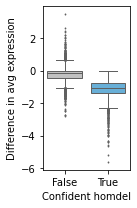

In [31]:
f, ax1 = plt.subplots(1, 1, figsize=(2,3), sharey=True)
df = hds_w_confidence.drop(columns=['depMapID']).drop_duplicates()
df = df.assign(expr_diff = -(df.other_expr - df.del_expr))
sns.boxplot(x='confident', y='expr_diff', data=df, ax=ax1, fliersize=1, linewidth=1, palette=['silver', '#56b4e9'])
ax1.set_ylabel('Difference in avg expression'); ax1.set_xlabel('Confident homdel')
plt.tight_layout()

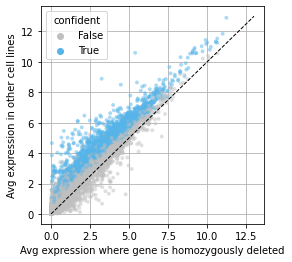

In [32]:
# Other expr should be > homdel expr
f, ax = plt.subplots(1, 1, figsize=(4,4))
sns.scatterplot(x='del_expr', y='other_expr', data=hds_w_confidence.drop(columns=['depMapID']).drop_duplicates(), 
                hue='confident', ax=ax, linewidth=0, alpha=0.5, s=15, palette=['silver', '#56b4e9'], zorder=2)
ax.plot([0, 13], [0, 13], linestyle='--', color='black', lw=1)
ax.set_xlabel('Avg expression where gene is homozygously deleted'); ax.set_ylabel('Avg expression in other cell lines')
ax.grid()